# 4.1 선형 회귀

In [28]:
import numpy as np
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

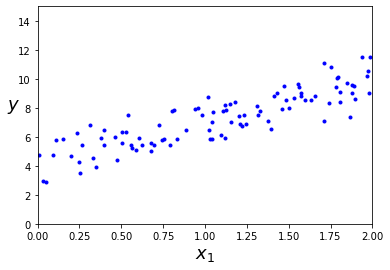

In [29]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

세타 계산

In [30]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.17795097],
       [2.87092976]])

예측

In [31]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.17795097],
       [9.91981048]])

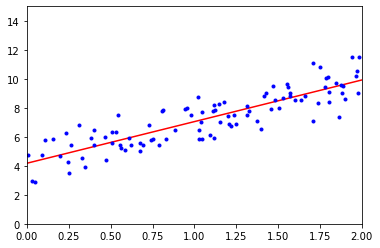

In [32]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

사이킷런에서 선형회귀 수행

In [33]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [34]:
lin_reg.intercept_,lin_reg.coef_

(array([4.17795097]), array([[2.87092976]]))

In [35]:
lin_reg.predict(X_new)

array([[4.17795097],
       [9.91981048]])

In [36]:
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[4.17795097],
       [2.87092976]])

유사역행열 직접 계산

In [37]:
np.linalg.pinv(X_b).dot(y)

array([[4.17795097],
       [2.87092976]])

# 4.2 경사하강법

In [38]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * gradients

In [39]:
theta

array([[4.17795097],
       [2.87092976]])

In [40]:
X_new_b.dot(theta)

array([[4.17795097],
       [9.91981048]])

In [41]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X,y,"b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration >0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0,2,0,15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

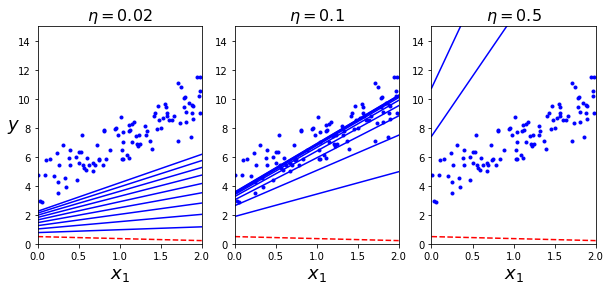

In [42]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

## 4.2.2 확률적 경사하강법
- 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레디언트를 계산 >> 훨씬 빠름, 매우 큰 훈련세트도 훈련가능
- 불안정하다    
   
딜레마 : local minimum을 벗어날 순 있지만 global minimum에 도달하지 못할 수 있음   
 -> 시작할 때는 learning rate를 크게하고 점친적으로 줄여나감. 매 반복에서 learning rate를 결정하는 함수를 learning schedule이라 한다 

In [43]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

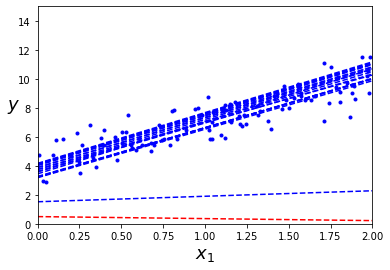

In [44]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t+t1)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b--" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)- yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

In [45]:
theta

array([[4.22904678],
       [2.85794702]])

In [46]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=5,penalty=None, eta0=0.1,random_state=42)
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, max_iter=5, penalty=None, random_state=42)

In [47]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.07787424]), array([3.01099591]))

## 4.2.3 미니배치 경사하강법

In [48]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 무작위 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [49]:
theta

array([[4.15518825],
       [2.86894633]])

In [50]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

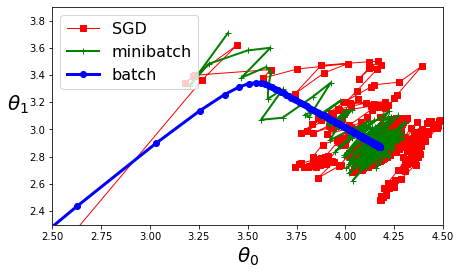

In [52]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="SGD")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="minibatch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
# save_fig("gradient_descent_paths_plot")
plt.show()